In [24]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

In [25]:
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=1,
            nbeats=1,
            dt_factor=1
            )
parameters = const.parameters

In [26]:
ti = 0.0
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()

while ti < const.T:

    if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
        dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    else:
        dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

   
    if abs(math.fmod(ti, 500)) < 1e-9:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    if abs(math.fmod(ti, dt_samp)) < 1e-8:
        phi_save.append(phi_new.clone())
    if any(torch.isnan(phi_new)):
        print('NaN detected in membrane potential!')
        break
    ti = round(ti + dt, 5) 
    # ti += dt
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
N: 1
Simulation time: 112.93 seconds


Text(0, 0.5, 'Membrane Potential (mV)')

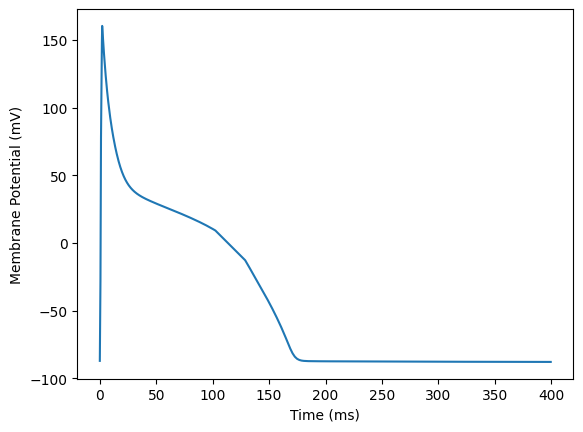

In [27]:
import matplotlib.pyplot as plt
phi_plot = phi_save[:, 0].cpu().numpy()
ts       = const.ts
plt.plot(ts, phi_plot)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')